# Taxi Fare Prediction

## Importing Data

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
import glob
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Connecting Google Drive with Colab to get Data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Reading Data

In [0]:
path = '/content/drive/My Drive/Data/'

Green Taxi Data

In [0]:
# Reading Data from multiple data files and combining them
all_files = glob.glob(path + 'Taxi_Data/*.csv')

li = []

for filename in all_files:
    # Find the month
    month = int(filename[-6:][0:2])
    if month < 7:
      temp_df = pd.read_csv(filename, index_col=None, header=0)
    else:
      temp_df = pd.read_csv(filename, header=None, names=['vendorid', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 
                                                          'store_and_fwd_flag', 'ratecodeid', 'pulocationid', 'dolocationid', 
                                                          'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 
                                                          'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
                                                          'total_amount', 'payment_type', 'trip_type', 'one', 'two'], skiprows=1)
    temp_df.columns = [x.lower() for x in temp_df.columns]
    temp_df = temp_df[['vendorid', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'ratecodeid', 'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type']]

    li.append(temp_df)

taxi_df = pd.concat(li, axis=0, ignore_index=True)

In [5]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16385532 entries, 0 to 16385531
Data columns (total 16 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   vendorid               int64  
 1   lpep_pickup_datetime   object 
 2   lpep_dropoff_datetime  object 
 3   store_and_fwd_flag     object 
 4   ratecodeid             int64  
 5   passenger_count        int64  
 6   trip_distance          float64
 7   fare_amount            float64
 8   extra                  float64
 9   mta_tax                float64
 10  tip_amount             float64
 11  tolls_amount           float64
 12  ehail_fee              float64
 13  improvement_surcharge  float64
 14  total_amount           float64
 15  payment_type           int64  
dtypes: float64(9), int64(4), object(3)
memory usage: 2.0+ GB


In [5]:
taxi_df.head(10)

,vendorid,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecodeid,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type
0,2,2016-01-01 00:29:24,2016-01-01 00:39:36,N,1,1,1.46,8.0,0.5,0.5,1.86,0.0,NaN,0.3,11.16,1
1,2,2016-01-01 00:19:39,2016-01-01 00:39:18,N,1,1,3.56,15.5,0.5,0.5,0.00,0.0,NaN,0.3,16.80,2
2,2,2016-01-01 00:19:33,2016-01-01 00:39:48,N,1,1,3.79,16.5,0.5,0.5,4.45,0.0,NaN,0.3,22.25,1
3,2,2016-01-01 00:22:12,2016-01-01 00:38:32,N,1,1,3.01,13.5,0.5,0.5,0.00,0.0,NaN,0.3,14.80,2
4,2,2016-01-01 00:24:01,2016-01-01 00:39:22,N,1,1,2.55,12.0,0.5,0.5,0.00,0.0,NaN,0.3,13.30,2
5,2,2016-01-01 00:32:59,2016-01-01 00:39:35,N,1,1,1.37,7.0,0.5,0.5,0.00,0.0,NaN,0.3,8.30,2
6,2,2016-01-01 00:34:42,2016-01-01 00:39:21,N,1,1,0.57,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2
7,2,2016-01-01 00:31:23,2016-01-01 00:39:36,N,1,1,1.01,7.0,0.5,0.5,0.00,0.0,NaN,0.3,8.30,2
8,2,2016-01-01 00:24:40,2016-01-01 00:39:52,N,1,1,2.46,12.0,0.5,0.5,2.00,0.0,NaN,0.3,15.30,1
9,2,2016-01-01 00:28:59,2016-01-01 00:39:23,N,1,1,1.61,9.0,0.5,0.5,1.60,0.0,NaN,0.3,11.90,1


In [6]:
taxi_df.describe()

,vendorid,ratecodeid,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type
count,1.638553e+07,1.638553e+07,1.638553e+07,1.638553e+07,1.638553e+07,1.638553e+07,1.638553e+07,1.638553e+07,1.638553e+07,0.0,1.638553e+07,1.638553e+07,1.638553e+07
mean,1.790590e+00,1.094279e+00,1.357557e+00,2.802718e+00,1.213675e+01,3.522082e-01,4.867317e-01,1.243873e+00,1.103113e-01,NaN,2.921152e-01,1.464115e+01,1.514710e+00
std,4.068873e-01,7.891883e-01,1.024279e+00,2.941111e+00,1.027957e+01,3.818636e-01,8.618982e-02,2.559969e+00,1.073319e+00,NaN,5.137505e-02,1.173573e+01,5.253130e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-4.990000e+02,-4.500000e+00,-5.000000e-01,-6.000000e+01,-5.000000e+01,NaN,-3.000000e-01,-4.990000e+02,1.000000e+00
25%,2.000000e+00,1.000000e+00,1.000000e+00,1.030000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,NaN,3.000000e-01,7.800000e+00,1.000000e+00
50%,2.000000e+00,1.000000e+00,1.000000e+00,1.840000e+00,9.500000e+00,5.000000e-01,5.000000e-01,0.000000e+00,0.000000e+00,NaN,3.000000e-01,1.130000e+01,2.000000e+00
75%,2.000000e+00,1.000000e+00,1.000000e+00,3.500000e+00,1.500000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,NaN,3.000000e-01,1.775000e+01,2.000000e+00
max,2.000000e+00,9.900000e+01,9.000000e+00,8.322000e+02,5.005500e+03,8.300000e+01,3.000000e+00,9.000000e+02,9.021700e+02,NaN,1.770000e+00,5.006300e+03,5.000000e+00


Weather Data

In [0]:
weather_csv = 'Monthly_Weather_Raw_JFK_Updated.csv'
weather_df = pd.read_csv(path+weather_csv)
weather_df.rename(columns={'Wind (mph) - Max': 'Wind (mph) - Avg',
                           'Wind (mph) - Avg': 'Wind (mph) - Min',
                           'Wind (mph) - Max?!?': 'Wind (mph) - Max'}, 
                  inplace=True)

In [7]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Month                        366 non-null    int64  
 1   Day                          366 non-null    int64  
 2   Temp. (Degrees F) - Max      366 non-null    int64  
 3   Temp. (Degrees F) - Avg      366 non-null    int64  
 4   Temp. (Degrees F) - Min      366 non-null    int64  
 5   Dew Point (Degrees F) - Max  366 non-null    int64  
 6   Dew Point (Degrees F) - Avg  366 non-null    int64  
 7   Dew Point (Degrees F) - Min  366 non-null    int64  
 8   Humidity (%) - Max           366 non-null    int64  
 9   Humidity (%) - Avg           366 non-null    int64  
 10  Humidity (%) - Min           366 non-null    int64  
 11  Sea Level Press. (in) - Max  366 non-null    float64
 12  Sea Level Press. (in) - Avg  366 non-null    float64
 13  Sea Level Press. (in

In [10]:
weather_df.head(10)

,Month,Day,Temp. (Degrees F) - Max,Temp. (Degrees F) - Avg,Temp. (Degrees F) - Min,Dew Point (Degrees F) - Max,Dew Point (Degrees F) - Avg,Dew Point (Degrees F) - Min,Humidity (%) - Max,Humidity (%) - Avg,Humidity (%) - Min,Sea Level Press. (in) - Max,Sea Level Press. (in) - Avg,Sea Level Press. (in) - Min,Visibility (mi) - Max,Visibility (mi) - Avg,Visibility (mi) - Min,Wind (mph) - Avg,Wind (mph) - Min,Wind (mph) - Max,Precipitation (in) - Sum,Event
0,1,1,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.00,NaN
1,1,2,41,38,34,22,19,17,52,47,41,30.12,30.04,29.98,10,10,10,24,13,30,0.00,NaN
2,1,3,48,42,35,27,23,21,64,49,34,29.96,29.88,29.80,10,10,10,23,14,29,0.00,NaN
3,1,4,38,27,15,25,10,-1,59,44,29,30.32,30.05,29.89,10,10,10,31,20,39,0.00,NaN
4,1,5,29,21,12,10,-2,-7,58,40,21,30.64,30.58,30.45,10,10,10,28,12,38,0.00,NaN
5,1,6,40,31,21,19,12,5,63,44,25,30.61,30.53,30.43,10,10,10,14,8,17,0.00,NaN
6,1,7,46,37,27,20,14,8,58,40,22,30.40,30.30,30.20,10,10,10,13,4,15,0.00,NaN
7,1,8,47,40,32,34,29,21,70,59,48,30.25,30.21,30.18,10,10,10,16,9,18,0.00,NaN
8,1,9,53,47,40,46,40,34,86,76,66,30.22,30.16,30.06,10,10,8,21,12,26,0.02,NaN
9,1,10,58,50,41,55,47,24,96,73,49,30.01,29.57,29.31,10,6,0,35,21,44,1.28,"Fog,Rain"


In [11]:
weather_df.describe()

,Month,Day,Temp. (Degrees F) - Max,Temp. (Degrees F) - Avg,Temp. (Degrees F) - Min,Dew Point (Degrees F) - Max,Dew Point (Degrees F) - Avg,Dew Point (Degrees F) - Min,Humidity (%) - Max,Humidity (%) - Avg,Humidity (%) - Min,Sea Level Press. (in) - Max,Sea Level Press. (in) - Avg,Sea Level Press. (in) - Min,Visibility (mi) - Max,Visibility (mi) - Avg,Visibility (mi) - Min,Wind (mph) - Avg,Wind (mph) - Min,Precipitation (in) - Sum
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,6.513661,15.756831,64.092896,57.021858,49.426230,49.920765,42.909836,35.734973,81.661202,62.978142,43.748634,30.141366,30.035383,29.933388,9.969945,9.423497,7.527322,22.191257,11.467213,0.097855
std,3.455958,8.823592,16.977410,16.507186,16.426966,17.743894,18.942597,20.317028,13.906142,13.535122,16.495983,0.194596,0.205746,0.218016,0.446200,1.315199,3.594984,7.152471,4.463277,0.286195
min,1.000000,1.000000,17.000000,9.000000,1.000000,-8.000000,-15.000000,-19.000000,36.000000,27.000000,11.000000,29.570000,29.350000,29.250000,2.000000,0.000000,0.000000,9.000000,4.000000,0.000000
25%,4.000000,8.000000,51.000000,44.250000,37.250000,37.000000,28.000000,20.000000,73.000000,53.000000,31.250000,30.010000,29.900000,29.810000,10.000000,10.000000,6.000000,16.000000,8.000000,0.000000
50%,7.000000,16.000000,64.000000,56.000000,47.500000,51.000000,43.000000,35.000000,86.000000,64.000000,42.000000,30.140000,30.040000,29.940000,10.000000,10.000000,10.000000,21.000000,11.000000,0.000000
75%,9.750000,23.000000,79.000000,73.000000,64.000000,65.000000,59.000000,52.000000,93.000000,73.000000,55.000000,30.250000,30.167500,30.087500,10.000000,10.000000,10.000000,28.000000,14.000000,0.020000
max,12.000000,31.000000,98.000000,89.000000,82.000000,84.000000,77.000000,75.000000,100.000000,92.000000,86.000000,30.750000,30.670000,30.500000,10.000000,10.000000,10.000000,49.000000,25.000000,2.900000


## Data Cleaning

Green Taxi Data

In [12]:
taxi_df.isnull().sum().sort_values(ascending = False)

ehail_fee                16385532
payment_type                    0
total_amount                    0
improvement_surcharge           0
tolls_amount                    0
tip_amount                      0
mta_tax                         0
extra                           0
fare_amount                     0
trip_distance                   0
passenger_count                 0
ratecodeid                      0
store_and_fwd_flag              0
lpep_dropoff_datetime           0
lpep_pickup_datetime            0
vendorid                        0
dtype: int64

In [0]:
final_taxi_df = taxi_df.drop(columns=['lpep_pickup_datetime', 
                                      'lpep_dropoff_datetime', 
                                      'ehail_fee',
                                      'payment_type',
                                      'tip_amount'])
final_taxi_df["Date"] = taxi_df["lpep_pickup_datetime"].apply(lambda x: x.split(' ')[0])
final_taxi_df["ratecodeid"] = final_taxi_df["ratecodeid"].astype(str)

In [9]:
final_taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16385532 entries, 0 to 16385531
Data columns (total 12 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   vendorid               int64  
 1   store_and_fwd_flag     object 
 2   ratecodeid             object 
 3   passenger_count        int64  
 4   trip_distance          float64
 5   fare_amount            float64
 6   extra                  float64
 7   mta_tax                float64
 8   tolls_amount           float64
 9   improvement_surcharge  float64
 10  total_amount           float64
 11  Date                   object 
dtypes: float64(7), int64(2), object(3)
memory usage: 1.5+ GB


In [14]:
final_taxi_df.head(10)

,vendorid,store_and_fwd_flag,ratecodeid,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,Date
0,2,N,1,1,1.46,8.0,0.5,0.5,0.0,0.3,11.16,2016-01-01
1,2,N,1,1,3.56,15.5,0.5,0.5,0.0,0.3,16.80,2016-01-01
2,2,N,1,1,3.79,16.5,0.5,0.5,0.0,0.3,22.25,2016-01-01
3,2,N,1,1,3.01,13.5,0.5,0.5,0.0,0.3,14.80,2016-01-01
4,2,N,1,1,2.55,12.0,0.5,0.5,0.0,0.3,13.30,2016-01-01
5,2,N,1,1,1.37,7.0,0.5,0.5,0.0,0.3,8.30,2016-01-01
6,2,N,1,1,0.57,5.0,0.5,0.5,0.0,0.3,6.30,2016-01-01
7,2,N,1,1,1.01,7.0,0.5,0.5,0.0,0.3,8.30,2016-01-01
8,2,N,1,1,2.46,12.0,0.5,0.5,0.0,0.3,15.30,2016-01-01
9,2,N,1,1,1.61,9.0,0.5,0.5,0.0,0.3,11.90,2016-01-01


Categorical Fields: vendorid, ratecodeid, store_and_fwd_flag

Weather Data

In [15]:
weather_df.isnull().sum().sort_values(ascending = False)

Event                          215
Precipitation (in) - Sum         0
Day                              0
Temp. (Degrees F) - Max          0
Temp. (Degrees F) - Avg          0
Temp. (Degrees F) - Min          0
Dew Point (Degrees F) - Max      0
Dew Point (Degrees F) - Avg      0
Dew Point (Degrees F) - Min      0
Humidity (%) - Max               0
Humidity (%) - Avg               0
Humidity (%) - Min               0
Sea Level Press. (in) - Max      0
Sea Level Press. (in) - Avg      0
Sea Level Press. (in) - Min      0
Visibility (mi) - Max            0
Visibility (mi) - Avg            0
Visibility (mi) - Min            0
Wind (mph) - Avg                 0
Wind (mph) - Min                 0
Wind (mph) - Max                 0
Month                            0
dtype: int64

In [0]:
final_weather_df = weather_df.drop(columns=['Event'])
final_weather_df["Day"] = final_weather_df["Day"].replace([1,2,3,4,5,6,7,8,9], ['01','02','03','04','05','06','07', '08', '09'])
final_weather_df["Month"] = final_weather_df["Month"].replace([1,2,3,4,5,6,7,8,9], ['01','02','03','04','05','06','07', '08', '09'])
final_weather_df["Date"] = "2016-" + final_weather_df["Month"].astype(str) + "-" + final_weather_df["Day"].astype(str)
final_weather_df = final_weather_df.drop(columns=['Day', 'Month'])
final_weather_df = final_weather_df[(final_weather_df['Wind (mph) - Max']!='-')]
final_weather_df["Wind (mph) - Max"] = final_weather_df["Wind (mph) - Max"].astype(int)

In [11]:
final_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360 entries, 0 to 365
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Temp. (Degrees F) - Max      360 non-null    int64  
 1   Temp. (Degrees F) - Avg      360 non-null    int64  
 2   Temp. (Degrees F) - Min      360 non-null    int64  
 3   Dew Point (Degrees F) - Max  360 non-null    int64  
 4   Dew Point (Degrees F) - Avg  360 non-null    int64  
 5   Dew Point (Degrees F) - Min  360 non-null    int64  
 6   Humidity (%) - Max           360 non-null    int64  
 7   Humidity (%) - Avg           360 non-null    int64  
 8   Humidity (%) - Min           360 non-null    int64  
 9   Sea Level Press. (in) - Max  360 non-null    float64
 10  Sea Level Press. (in) - Avg  360 non-null    float64
 11  Sea Level Press. (in) - Min  360 non-null    float64
 12  Visibility (mi) - Max        360 non-null    int64  
 13  Visibility (mi) - Av

In [12]:
final_weather_df.head(10)

,Temp. (Degrees F) - Max,Temp. (Degrees F) - Avg,Temp. (Degrees F) - Min,Dew Point (Degrees F) - Max,Dew Point (Degrees F) - Avg,Dew Point (Degrees F) - Min,Humidity (%) - Max,Humidity (%) - Avg,Humidity (%) - Min,Sea Level Press. (in) - Max,Sea Level Press. (in) - Avg,Sea Level Press. (in) - Min,Visibility (mi) - Max,Visibility (mi) - Avg,Visibility (mi) - Min,Wind (mph) - Avg,Wind (mph) - Min,Wind (mph) - Max,Precipitation (in) - Sum,Date
0,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.00,2016-01-01
1,41,38,34,22,19,17,52,47,41,30.12,30.04,29.98,10,10,10,24,13,30,0.00,2016-01-02
2,48,42,35,27,23,21,64,49,34,29.96,29.88,29.80,10,10,10,23,14,29,0.00,2016-01-03
3,38,27,15,25,10,-1,59,44,29,30.32,30.05,29.89,10,10,10,31,20,39,0.00,2016-01-04
4,29,21,12,10,-2,-7,58,40,21,30.64,30.58,30.45,10,10,10,28,12,38,0.00,2016-01-05
5,40,31,21,19,12,5,63,44,25,30.61,30.53,30.43,10,10,10,14,8,17,0.00,2016-01-06
6,46,37,27,20,14,8,58,40,22,30.40,30.30,30.20,10,10,10,13,4,15,0.00,2016-01-07
7,47,40,32,34,29,21,70,59,48,30.25,30.21,30.18,10,10,10,16,9,18,0.00,2016-01-08
8,53,47,40,46,40,34,86,76,66,30.22,30.16,30.06,10,10,8,21,12,26,0.02,2016-01-09
9,58,50,41,55,47,24,96,73,49,30.01,29.57,29.31,10,6,0,35,21,44,1.28,2016-01-10


Merging Data

In [0]:
final_df = final_taxi_df.merge(right=final_weather_df, on='Date')

In [14]:
final_df.head(10)

,vendorid,store_and_fwd_flag,ratecodeid,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,Date,Temp. (Degrees F) - Max,Temp. (Degrees F) - Avg,Temp. (Degrees F) - Min,Dew Point (Degrees F) - Max,Dew Point (Degrees F) - Avg,Dew Point (Degrees F) - Min,Humidity (%) - Max,Humidity (%) - Avg,Humidity (%) - Min,Sea Level Press. (in) - Max,Sea Level Press. (in) - Avg,Sea Level Press. (in) - Min,Visibility (mi) - Max,Visibility (mi) - Avg,Visibility (mi) - Min,Wind (mph) - Avg,Wind (mph) - Min,Wind (mph) - Max,Precipitation (in) - Sum
0,2,N,1,1,1.46,8.0,0.5,0.5,0.0,0.3,11.16,2016-01-01,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0
1,2,N,1,1,3.56,15.5,0.5,0.5,0.0,0.3,16.80,2016-01-01,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0
2,2,N,1,1,3.79,16.5,0.5,0.5,0.0,0.3,22.25,2016-01-01,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0
3,2,N,1,1,3.01,13.5,0.5,0.5,0.0,0.3,14.80,2016-01-01,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0
4,2,N,1,1,2.55,12.0,0.5,0.5,0.0,0.3,13.30,2016-01-01,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0
5,2,N,1,1,1.37,7.0,0.5,0.5,0.0,0.3,8.30,2016-01-01,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0
6,2,N,1,1,0.57,5.0,0.5,0.5,0.0,0.3,6.30,2016-01-01,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0
7,2,N,1,1,1.01,7.0,0.5,0.5,0.0,0.3,8.30,2016-01-01,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0
8,2,N,1,1,2.46,12.0,0.5,0.5,0.0,0.3,15.30,2016-01-01,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0
9,2,N,1,1,1.61,9.0,0.5,0.5,0.0,0.3,11.90,2016-01-01,44,40,36,28,24,18,59,50,40,30.08,30.04,29.99,10,10,10,28,15,33,0.0


In [15]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16103149 entries, 0 to 16103148
Data columns (total 31 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   vendorid                     int64  
 1   store_and_fwd_flag           object 
 2   ratecodeid                   object 
 3   passenger_count              int64  
 4   trip_distance                float64
 5   fare_amount                  float64
 6   extra                        float64
 7   mta_tax                      float64
 8   tolls_amount                 float64
 9   improvement_surcharge        float64
 10  total_amount                 float64
 11  Date                         object 
 12  Temp. (Degrees F) - Max      int64  
 13  Temp. (Degrees F) - Avg      int64  
 14  Temp. (Degrees F) - Min      int64  
 15  Dew Point (Degrees F) - Max  int64  
 16  Dew Point (Degrees F) - Avg  int64  
 17  Dew Point (Degrees F) - Min  int64  
 18  Humidity (%) - Max           int64  
 19

In [20]:
final_df.isnull().sum().sort_values(ascending = False)

Precipitation (in) - Sum       0
Temp. (Degrees F) - Min        0
store_and_fwd_flag             0
ratecodeid                     0
passenger_count                0
trip_distance                  0
fare_amount                    0
extra                          0
mta_tax                        0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
Date                           0
Temp. (Degrees F) - Max        0
Temp. (Degrees F) - Avg        0
Dew Point (Degrees F) - Max    0
Wind (mph) - Max               0
Dew Point (Degrees F) - Avg    0
Dew Point (Degrees F) - Min    0
Humidity (%) - Max             0
Humidity (%) - Avg             0
Humidity (%) - Min             0
Sea Level Press. (in) - Max    0
Sea Level Press. (in) - Avg    0
Sea Level Press. (in) - Min    0
Visibility (mi) - Max          0
Visibility (mi) - Avg          0
Visibility (mi) - Min          0
Wind (mph) - Avg               0
Wind (mph) - Min               0
vendorid  

In [21]:
final_df.describe()

,vendorid,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,Temp. (Degrees F) - Max,Temp. (Degrees F) - Avg,Temp. (Degrees F) - Min,Dew Point (Degrees F) - Max,Dew Point (Degrees F) - Avg,Dew Point (Degrees F) - Min,Humidity (%) - Max,Humidity (%) - Avg,Humidity (%) - Min,Sea Level Press. (in) - Max,Sea Level Press. (in) - Avg,Sea Level Press. (in) - Min,Visibility (mi) - Max,Visibility (mi) - Avg,Visibility (mi) - Min,Wind (mph) - Avg,Wind (mph) - Min,Wind (mph) - Max,Precipitation (in) - Sum
count,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07,1.610315e+07
mean,1.790551e+00,1.357451e+00,2.800610e+00,1.213177e+01,3.527233e-01,4.867222e-01,1.103122e-01,2.921090e-01,1.463603e+01,6.323052e+01,5.615868e+01,4.855953e+01,4.907218e+01,4.192686e+01,3.463558e+01,8.150236e+01,6.274236e+01,4.342664e+01,3.013704e+01,3.002911e+01,2.992494e+01,9.985267e+00,9.420415e+00,7.476127e+00,2.247283e+01,1.156079e+01,2.835948e+01,9.198428e-02
std,4.069150e-01,1.024237e+00,2.940234e+00,1.028561e+01,3.824330e-01,8.621508e-02,1.076703e+00,5.139784e-02,1.174070e+01,1.693830e+01,1.643144e+01,1.631286e+01,1.772626e+01,1.900555e+01,2.040831e+01,1.408395e+01,1.364547e+01,1.658989e+01,1.958383e-01,2.086431e-01,2.222048e-01,2.671771e-01,1.272309e+00,3.607397e+00,7.144173e+00,4.455026e+00,9.318024e+00,2.495659e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,-4.990000e+02,-4.500000e+00,-5.000000e-01,-5.000000e+01,-3.000000e-01,-4.990000e+02,1.700000e+01,9.000000e+00,1.000000e+00,-8.000000e+00,-1.500000e+01,-1.900000e+01,3.600000e+01,2.700000e+01,1.100000e+01,2.957000e+01,2.935000e+01,2.925000e+01,2.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,4.000000e+00,1.200000e+01,0.000000e+00
25%,2.000000e+00,1.000000e+00,1.030000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,3.000000e-01,7.800000e+00,5.000000e+01,4.300000e+01,3.700000e+01,3.700000e+01,2.700000e+01,1.900000e+01,7.300000e+01,5.200000e+01,3.100000e+01,3.000000e+01,2.989000e+01,2.980000e+01,1.000000e+01,1.000000e+01,5.000000e+00,1.700000e+01,8.000000e+00,2.200000e+01,0.000000e+00
50%,2.000000e+00,1.000000e+00,1.830000e+00,9.500000e+00,5.000000e-01,5.000000e-01,0.000000e+00,3.000000e-01,1.130000e+01,6.300000e+01,5.500000e+01,4.700000e+01,5.000000e+01,4.200000e+01,3.400000e+01,8.600000e+01,6.400000e+01,4.200000e+01,3.014000e+01,3.004000e+01,2.994000e+01,1.000000e+01,1.000000e+01,1.000000e+01,2.200000e+01,1.100000e+01,2.600000e+01,0.000000e+00
75%,2.000000e+00,1.000000e+00,3.500000e+00,1.500000e+01,5.000000e-01,5.000000e-01,0.000000e+00,3.000000e-01,1.775000e+01,7.800000e+01,7.100000e+01,6.300000e+01,6.400000e+01,5.800000e+01,5.000000e+01,9.300000e+01,7.300000e+01,5.400000e+01,3.025000e+01,3.016000e+01,3.008000e+01,1.000000e+01,1.000000e+01,1.000000e+01,2.800000e+01,1.400000e+01,3.500000e+01,3.000000e-02
max,2.000000e+00,9.000000e+00,8.322000e+02,5.005500e+03,8.300000e+01,3.000000e+00,9.021700e+02,1.770000e+00,5.006300e+03,9.800000e+01,8.900000e+01,8.200000e+01,8.400000e+01,7.700000e+01,7.500000e+01,1.000000e+02,9.200000e+01,8.600000e+01,3.075000e+01,3.067000e+01,3.050000e+01,1.000000e+01,1.000000e+01,1.000000e+01,4.900000e+01,2.500000e+01,6.400000e+01,2.900000e+00


Removing Outliers

In [0]:
final_df = final_df[(final_df['trip_distance']>0.0) & (final_df['trip_distance']<=400.0) &
                    (final_df['extra']>=0.0) & (final_df['fare_amount']>0.0) &
                    (final_df['mta_tax']>0.0) & (final_df['tolls_amount']>=0.0) &
                    (final_df['improvement_surcharge']>=0.0) & (final_df['total_amount']>0.0)]

In [23]:
final_df.describe()

,vendorid,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,Temp. (Degrees F) - Max,Temp. (Degrees F) - Avg,Temp. (Degrees F) - Min,Dew Point (Degrees F) - Max,Dew Point (Degrees F) - Avg,Dew Point (Degrees F) - Min,Humidity (%) - Max,Humidity (%) - Avg,Humidity (%) - Min,Sea Level Press. (in) - Max,Sea Level Press. (in) - Avg,Sea Level Press. (in) - Min,Visibility (mi) - Max,Visibility (mi) - Avg,Visibility (mi) - Min,Wind (mph) - Avg,Wind (mph) - Min,Wind (mph) - Max,Precipitation (in) - Sum
count,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07,1.558878e+07
mean,1.791433e+00,1.358605e+00,2.811961e+00,1.200828e+01,3.620787e-01,5.000181e-01,1.051642e-01,2.997854e-01,1.453731e+01,6.322065e+01,5.614964e+01,4.855151e+01,4.906548e+01,4.191910e+01,3.462638e+01,8.150114e+01,6.274290e+01,4.342869e+01,3.013706e+01,3.002909e+01,2.992488e+01,9.985285e+00,9.420045e+00,7.474674e+00,2.247431e+01,1.156180e+01,2.836173e+01,9.205432e-02
std,4.062842e-01,1.029048e+00,2.847875e+00,9.049925e+00,3.794841e-01,6.732231e-03,9.413199e-01,8.133738e-03,1.051622e+01,1.693588e+01,1.642864e+01,1.630958e+01,1.772482e+01,1.900372e+01,2.040668e+01,1.408451e+01,1.364616e+01,1.659091e+01,1.958820e-01,2.087075e-01,2.222836e-01,2.670365e-01,1.272662e+00,3.608097e+00,7.145128e+00,4.455219e+00,9.319010e+00,2.495296e-01
min,1.000000e+00,0.000000e+00,1.000000e-02,1.000000e-02,0.000000e+00,4.000000e-01,0.000000e+00,0.000000e+00,5.100000e-01,1.700000e+01,9.000000e+00,1.000000e+00,-8.000000e+00,-1.500000e+01,-1.900000e+01,3.600000e+01,2.700000e+01,1.100000e+01,2.957000e+01,2.935000e+01,2.925000e+01,2.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,4.000000e+00,1.200000e+01,0.000000e+00
25%,2.000000e+00,1.000000e+00,1.060000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,3.000000e-01,8.000000e+00,5.000000e+01,4.300000e+01,3.700000e+01,3.700000e+01,2.700000e+01,1.900000e+01,7.300000e+01,5.200000e+01,3.100000e+01,3.000000e+01,2.989000e+01,2.980000e+01,1.000000e+01,1.000000e+01,5.000000e+00,1.700000e+01,8.000000e+00,2.200000e+01,0.000000e+00
50%,2.000000e+00,1.000000e+00,1.860000e+00,9.000000e+00,5.000000e-01,5.000000e-01,0.000000e+00,3.000000e-01,1.130000e+01,6.300000e+01,5.500000e+01,4.700000e+01,5.000000e+01,4.200000e+01,3.400000e+01,8.600000e+01,6.400000e+01,4.200000e+01,3.014000e+01,3.004000e+01,2.994000e+01,1.000000e+01,1.000000e+01,1.000000e+01,2.200000e+01,1.100000e+01,2.600000e+01,0.000000e+00
75%,2.000000e+00,1.000000e+00,3.500000e+00,1.450000e+01,5.000000e-01,5.000000e-01,0.000000e+00,3.000000e-01,1.740000e+01,7.800000e+01,7.100000e+01,6.300000e+01,6.400000e+01,5.800000e+01,5.000000e+01,9.300000e+01,7.300000e+01,5.400000e+01,3.025000e+01,3.016000e+01,3.008000e+01,1.000000e+01,1.000000e+01,1.000000e+01,2.800000e+01,1.400000e+01,3.500000e+01,3.000000e-02
max,2.000000e+00,9.000000e+00,3.605000e+02,5.005500e+03,8.300000e+01,3.000000e+00,9.021700e+02,1.770000e+00,5.006300e+03,9.800000e+01,8.900000e+01,8.200000e+01,8.400000e+01,7.700000e+01,7.500000e+01,1.000000e+02,9.200000e+01,8.600000e+01,3.075000e+01,3.067000e+01,3.050000e+01,1.000000e+01,1.000000e+01,1.000000e+01,4.900000e+01,2.500000e+01,6.400000e+01,2.900000e+00


In [11]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15588782 entries, 0 to 16103148
Data columns (total 31 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   vendorid                     int64  
 1   store_and_fwd_flag           object 
 2   ratecodeid                   object 
 3   passenger_count              int64  
 4   trip_distance                float64
 5   fare_amount                  float64
 6   extra                        float64
 7   mta_tax                      float64
 8   tolls_amount                 float64
 9   improvement_surcharge        float64
 10  total_amount                 float64
 11  Date                         object 
 12  Temp. (Degrees F) - Max      int64  
 13  Temp. (Degrees F) - Avg      int64  
 14  Temp. (Degrees F) - Min      int64  
 15  Dew Point (Degrees F) - Max  int64  
 16  Dew Point (Degrees F) - Avg  int64  
 17  Dew Point (Degrees F) - Min  int64  
 18  Humidity (%) - Max           int64  
 19

In [0]:
final_df = final_df.sample(n=10000000)

In [18]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000000 entries, 1999897 to 3773251
Data columns (total 31 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   vendorid                     int64  
 1   store_and_fwd_flag           object 
 2   ratecodeid                   object 
 3   passenger_count              int64  
 4   trip_distance                float64
 5   fare_amount                  float64
 6   extra                        float64
 7   mta_tax                      float64
 8   tolls_amount                 float64
 9   improvement_surcharge        float64
 10  total_amount                 float64
 11  Date                         object 
 12  Temp. (Degrees F) - Max      int64  
 13  Temp. (Degrees F) - Avg      int64  
 14  Temp. (Degrees F) - Min      int64  
 15  Dew Point (Degrees F) - Max  int64  
 16  Dew Point (Degrees F) - Avg  int64  
 17  Dew Point (Degrees F) - Min  int64  
 18  Humidity (%) - Max           int64 

## Models

Linear Regression (Baseline)

In [0]:
def linear_regression(train_data, test_data, train_labels, test_labels):
  lg = LinearRegression()  
  lg.fit(train_data, train_labels)
  predictions = lg.predict(test_data)
  performance(lg, predictions, test_labels)

Lasso

In [0]:
def lasso(n, train_data, test_data, train_labels, test_labels):
  ls = Lasso(alpha=n)
  ls.fit(train_data, train_labels)
  predictions = ls.predict(test_data)
  performance(ls, predictions, test_labels)

Gradient boost

In [0]:
def gradient_boosting(n, train_data, test_data, train_labels, test_labels):
  gb = DecisionTreeRegressor(max_depth=n)
  gb.fit(train_data, train_labels)
  predictions = gb.predict(test_data)
  performance(gb, predictions, test_labels)

Random Forest

In [0]:
def random_forest(n, train_data, test_data, train_labels, test_labels):
  rf = RandomForestRegressor(n_estimators = n, random_state = 42)
  rf.fit(train_data, train_labels)
  predictions = rf.predict(test_data)
  performance(rf, predictions, test_labels)

## Performance

In [0]:
def performance(mod, predictions, test_labels):
  errors = abs(predictions - test_labels)
  mape = 100 * (errors / test_labels)
  print('Mean Absolute Error:', metrics.mean_absolute_error(predictions, test_labels))
  print('Mean Squared Error:', metrics.mean_squared_error(predictions, test_labels))
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(predictions, test_labels)))
  accu = 100 - np.mean(mape)
  print('Accuracy:', round(accu, 2), '%')

## Run 1

In [0]:
# Drop the categorical variables
run1_df = final_df.drop(columns=['vendorid', 'store_and_fwd_flag', 'ratecodeid', 'Date'])

In [16]:
run1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000000 entries, 4896936 to 13421204
Data columns (total 27 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   passenger_count              int64  
 1   trip_distance                float64
 2   fare_amount                  float64
 3   extra                        float64
 4   mta_tax                      float64
 5   tolls_amount                 float64
 6   improvement_surcharge        float64
 7   total_amount                 float64
 8   Temp. (Degrees F) - Max      int64  
 9   Temp. (Degrees F) - Avg      int64  
 10  Temp. (Degrees F) - Min      int64  
 11  Dew Point (Degrees F) - Max  int64  
 12  Dew Point (Degrees F) - Avg  int64  
 13  Dew Point (Degrees F) - Min  int64  
 14  Humidity (%) - Max           int64  
 15  Humidity (%) - Avg           int64  
 16  Humidity (%) - Min           int64  
 17  Sea Level Press. (in) - Max  float64
 18  Sea Level Press. (in) - Avg  float

Features and Labels

In [0]:
labels = run1_df['total_amount']

In [0]:
features = run1_df.drop(columns='total_amount')
feature_list = list(features.columns)
features = np.array(features)

Train-Test Split

In [0]:
run1_train_features_df, run1_test_features_df, run1_train_labels_df, run1_test_labels_df = train_test_split(features, labels, test_size=0.2, random_state=42)

Linear Regression (Baseline)

In [22]:
linear_regression(run1_train_features_df, run1_test_features_df, run1_train_labels_df, run1_test_labels_df)

Mean Absolute Error: 1.3394067045453109
Mean Squared Error: 4.500328367193192
Root Mean Squared Error: 2.1213977390374468
Accuracy: 90.84 %


Lasso

In [26]:
lasso(1, run1_train_features_df, run1_test_features_df, run1_train_labels_df, run1_test_labels_df)

Mean Absolute Error: 1.4298388101587864
Mean Squared Error: 5.506199914167465
Root Mean Squared Error: 2.346529333753888
Accuracy: 90.21 %


Gradient boost

In [27]:
gradient_boosting(10, run1_train_features_df, run1_test_features_df, run1_train_labels_df, run1_test_labels_df)

Mean Absolute Error: 1.335636708084491
Mean Squared Error: 4.816445087100021
Root Mean Squared Error: 2.1946400814484415
Accuracy: 90.81 %


Random Forest

In [28]:
random_forest(3, run1_train_features_df, run1_test_features_df, run1_train_labels_df, run1_test_labels_df)

Mean Absolute Error: 1.4186619090945627
Mean Squared Error: 6.461870881592657
Root Mean Squared Error: 2.542021023043015
Accuracy: 90.32 %


## Run 2

In [0]:
run2_df = final_df.drop(columns=['Date'])

In [25]:
run2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000000 entries, 1999897 to 3773251
Data columns (total 30 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   vendorid                     int64  
 1   store_and_fwd_flag           object 
 2   ratecodeid                   object 
 3   passenger_count              int64  
 4   trip_distance                float64
 5   fare_amount                  float64
 6   extra                        float64
 7   mta_tax                      float64
 8   tolls_amount                 float64
 9   improvement_surcharge        float64
 10  total_amount                 float64
 11  Temp. (Degrees F) - Max      int64  
 12  Temp. (Degrees F) - Avg      int64  
 13  Temp. (Degrees F) - Min      int64  
 14  Dew Point (Degrees F) - Max  int64  
 15  Dew Point (Degrees F) - Avg  int64  
 16  Dew Point (Degrees F) - Min  int64  
 17  Humidity (%) - Max           int64  
 18  Humidity (%) - Avg           int64 

Features and Labels

In [0]:
labels = run2_df['total_amount']

In [0]:
features = run2_df.drop(columns='total_amount')

One-Hot Encoding

In [0]:
features = pd.get_dummies(features)

In [0]:
features.iloc[:,5:].head(5)

In [0]:
features.info()

In [0]:
feature_list = list(features.columns)
features = np.array(features)

Train-Test Split

In [0]:
run2_train_features_df, run2_test_features_df, run2_train_labels_df, run2_test_labels_df = train_test_split(features, labels, test_size=0.2, random_state=42)

Linear Regression (Baseline)

In [31]:
linear_regression(run2_train_features_df, run2_test_features_df, run2_train_labels_df, run2_test_labels_df)

Mean Absolute Error: 1.3406468260695228
Mean Squared Error: 4.650101514266171
Root Mean Squared Error: 2.1564094032131678
Accuracy: 90.84 %


Lasso

In [33]:
lasso(1, run2_train_features_df, run2_test_features_df, run2_train_labels_df, run2_test_labels_df)

Mean Absolute Error: 1.432948601115237
Mean Squared Error: 6.278178157781384
Root Mean Squared Error: 2.5056292937666145
Accuracy: 90.2 %


Gradient Boosting

In [34]:
gradient_boosting(10, run2_train_features_df, run2_test_features_df, run2_train_labels_df, run2_test_labels_df)

Mean Absolute Error: 1.3380909644765462
Mean Squared Error: 6.444186061452252
Root Mean Squared Error: 2.5385401437543296
Accuracy: 90.8 %


Random Forest

In [35]:
random_forest(3, run2_train_features_df, run2_test_features_df, run2_train_labels_df, run2_test_labels_df)

Mean Absolute Error: 1.4215463940458877
Mean Squared Error: 8.168031576598473
Root Mean Squared Error: 2.8579768327609782
Accuracy: 90.31 %


# NYC Weather Transportation Study

In [0]:
avg_taxi_csv = "Green Taxi Average.csv"
avg_taxi_df = pd.read_csv(path + avg_taxi_csv)

In [37]:
avg_taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             366 non-null    object 
 1   Total_Passenger  366 non-null    int64  
 2   Avg_Passen       366 non-null    float64
 3   Total_trip       366 non-null    int64  
 4   Total_dist(mi)   366 non-null    float64
 5   Avg_Dist(mi)     366 non-null    float64
 6   Avg_speed(mi/h)  366 non-null    float64
 7   Avg_duration(s)  366 non-null    float64
dtypes: float64(5), int64(2), object(1)
memory usage: 23.0+ KB


In [38]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Month                        366 non-null    int64  
 1   Day                          366 non-null    int64  
 2   Temp. (Degrees F) - Max      366 non-null    int64  
 3   Temp. (Degrees F) - Avg      366 non-null    int64  
 4   Temp. (Degrees F) - Min      366 non-null    int64  
 5   Dew Point (Degrees F) - Max  366 non-null    int64  
 6   Dew Point (Degrees F) - Avg  366 non-null    int64  
 7   Dew Point (Degrees F) - Min  366 non-null    int64  
 8   Humidity (%) - Max           366 non-null    int64  
 9   Humidity (%) - Avg           366 non-null    int64  
 10  Humidity (%) - Min           366 non-null    int64  
 11  Sea Level Press. (in) - Max  366 non-null    float64
 12  Sea Level Press. (in) - Avg  366 non-null    float64
 13  Sea Level Press. (in

Data Cleaning

Average Taxi Data

In [0]:
avg_taxi_df = avg_taxi_df.drop(columns=['Date'])

Weather Data

In [0]:
new_weather_df = weather_df.drop(columns=['Month', 
                                          'Day', 
                                          'Temp. (Degrees F) - Max',
                                          'Temp. (Degrees F) - Min',
                                          'Dew Point (Degrees F) - Max',
                                          'Dew Point (Degrees F) - Min',
                                          'Humidity (%) - Max',
                                          'Humidity (%) - Min',
                                          'Sea Level Press. (in) - Max',
                                          'Sea Level Press. (in) - Min',
                                          'Visibility (mi) - Max',
                                          'Visibility (mi) - Min',
                                          'Wind (mph) - Min',
                                          'Wind (mph) - Max',
                                          'Event'])

In [41]:
new_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Temp. (Degrees F) - Avg      366 non-null    int64  
 1   Dew Point (Degrees F) - Avg  366 non-null    int64  
 2   Humidity (%) - Avg           366 non-null    int64  
 3   Sea Level Press. (in) - Avg  366 non-null    float64
 4   Visibility (mi) - Avg        366 non-null    int64  
 5   Wind (mph) - Avg             366 non-null    int64  
 6   Precipitation (in) - Sum     366 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 20.1 KB


Merge Average Taxi and Weather Data

In [0]:
result_df = pd.concat([avg_taxi_df, new_weather_df], axis=1)

In [43]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Total_Passenger              366 non-null    int64  
 1   Avg_Passen                   366 non-null    float64
 2   Total_trip                   366 non-null    int64  
 3   Total_dist(mi)               366 non-null    float64
 4   Avg_Dist(mi)                 366 non-null    float64
 5   Avg_speed(mi/h)              366 non-null    float64
 6   Avg_duration(s)              366 non-null    float64
 7   Temp. (Degrees F) - Avg      366 non-null    int64  
 8   Dew Point (Degrees F) - Avg  366 non-null    int64  
 9   Humidity (%) - Avg           366 non-null    int64  
 10  Sea Level Press. (in) - Avg  366 non-null    float64
 11  Visibility (mi) - Avg        366 non-null    int64  
 12  Wind (mph) - Avg             366 non-null    int64  
 13  Precipitation (in) -

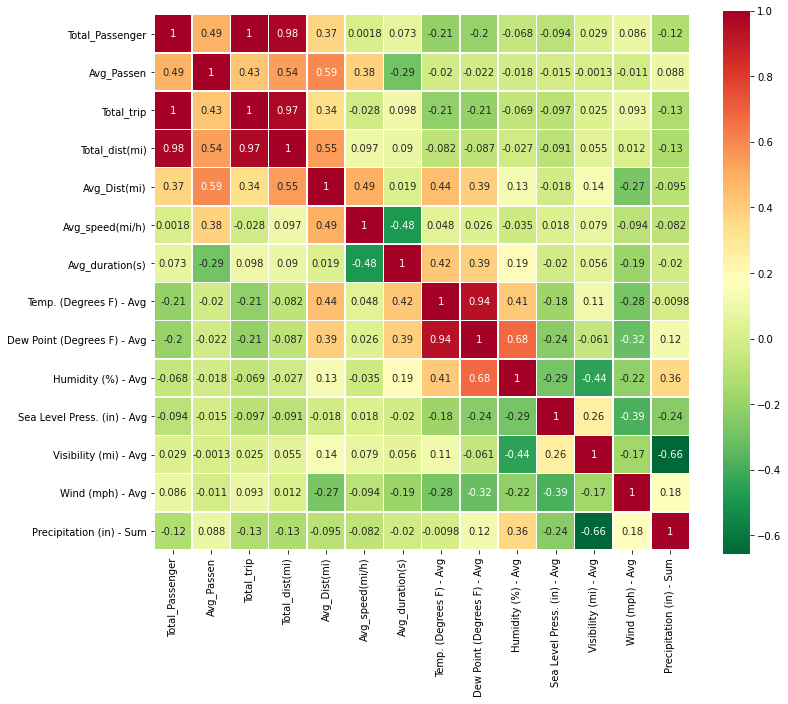

In [44]:
heatmap_plot = sns.heatmap(
                            result_df.corr(),
                            cmap='RdYlGn_r',
                            square=True,
                            ax = plt.subplots(figsize = (12,10))[1],
                            annot=True,
                            linewidths=.5
                          )

# Influence of Distance/Duration on extra fare

In [0]:
influence_df = taxi_df[['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'trip_distance', 'extra']]

In [50]:
influence_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16385532 entries, 0 to 16385531
Data columns (total 4 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   lpep_pickup_datetime   object 
 1   lpep_dropoff_datetime  object 
 2   trip_distance          float64
 3   extra                  float64
dtypes: float64(2), object(2)
memory usage: 500.0+ MB


In [51]:
influence_df.head(10)

,lpep_pickup_datetime,lpep_dropoff_datetime,trip_distance,extra
0,2016-01-01 00:29:24,2016-01-01 00:39:36,1.46,0.5
1,2016-01-01 00:19:39,2016-01-01 00:39:18,3.56,0.5
2,2016-01-01 00:19:33,2016-01-01 00:39:48,3.79,0.5
3,2016-01-01 00:22:12,2016-01-01 00:38:32,3.01,0.5
4,2016-01-01 00:24:01,2016-01-01 00:39:22,2.55,0.5
5,2016-01-01 00:32:59,2016-01-01 00:39:35,1.37,0.5
6,2016-01-01 00:34:42,2016-01-01 00:39:21,0.57,0.5
7,2016-01-01 00:31:23,2016-01-01 00:39:36,1.01,0.5
8,2016-01-01 00:24:40,2016-01-01 00:39:52,2.46,0.5
9,2016-01-01 00:28:59,2016-01-01 00:39:23,1.61,0.5


Calculating Total Trip duration

In [52]:
influence_df["trip_duration"] = (pd.to_datetime(influence_df['lpep_dropoff_datetime'], format="%Y-%m-%d %H:%M:%S") - pd.to_datetime(influence_df['lpep_pickup_datetime'], format="%Y-%m-%d %H:%M:%S")) / np.timedelta64(1, 'm')
influence_df = influence_df[influence_df['trip_duration'] >= 0]
influence_df = influence_df.drop(columns=['lpep_dropoff_datetime', 'lpep_pickup_datetime'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [53]:
influence_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16385431 entries, 0 to 16385531
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   trip_distance  float64
 1   extra          float64
 2   trip_duration  float64
dtypes: float64(3)
memory usage: 500.0 MB


In [54]:
influence_df.head(10)

,trip_distance,extra,trip_duration
0,1.46,0.5,10.200000
1,3.56,0.5,19.650000
2,3.79,0.5,20.250000
3,3.01,0.5,16.333333
4,2.55,0.5,15.350000
5,1.37,0.5,6.600000
6,0.57,0.5,4.650000
7,1.01,0.5,8.216667
8,2.46,0.5,15.200000
9,1.61,0.5,10.400000


### Influence trip distance on extra

In [0]:
dist_extra_df = influence_df[['trip_distance', 'extra']]

In [56]:
dist_extra_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16385431 entries, 0 to 16385531
Data columns (total 2 columns):
 #   Column         Dtype  
---  ------         -----  
 0   trip_distance  float64
 1   extra          float64
dtypes: float64(2)
memory usage: 375.0 MB


In [57]:
dist_extra_df.head(10)

,trip_distance,extra
0,1.46,0.5
1,3.56,0.5
2,3.79,0.5
3,3.01,0.5
4,2.55,0.5
5,1.37,0.5
6,0.57,0.5
7,1.01,0.5
8,2.46,0.5
9,1.61,0.5


Data Cleaning

In [0]:
dist_extra_df = dist_extra_df[(dist_extra_df['extra']>0.0)]

Features and Labels

In [0]:
labels = dist_extra_df['extra']

In [0]:
features = dist_extra_df.drop(columns='extra')
feature_list = list(features.columns)
features = np.array(features)

Train-Test Split

In [0]:
dist_extra_train_features_df, dist_extra_test_features_df, dist_extra_train_labels_df, dist_extra_test_labels_df = train_test_split(features, labels, test_size=0.2, random_state=42)

Linear Regression (Baseline)

In [62]:
linear_regression(dist_extra_train_features_df, dist_extra_test_features_df, dist_extra_train_labels_df, dist_extra_test_labels_df)

Mean Absolute Error: 0.2195125229047787
Mean Squared Error: 0.06545588217664941
Root Mean Squared Error: 0.2558434720227378
Accuracy: 67.29 %


Lasso

In [63]:
lasso(1, dist_extra_train_features_df, dist_extra_test_features_df, dist_extra_train_labels_df, dist_extra_test_labels_df)

Mean Absolute Error: 0.2203982973172891
Mean Squared Error: 0.06557662100276435
Root Mean Squared Error: 0.256079325605884
Accuracy: 67.16 %


Gradient Boosting

In [64]:
gradient_boosting(10, dist_extra_train_features_df, dist_extra_test_features_df, dist_extra_train_labels_df, dist_extra_test_labels_df)

Mean Absolute Error: 0.21808819178010416
Mean Squared Error: 0.06411594546233815
Root Mean Squared Error: 0.2532112664601205
Accuracy: 67.49 %


Random Forest

In [65]:
random_forest(3, dist_extra_train_features_df, dist_extra_test_features_df, dist_extra_train_labels_df, dist_extra_test_labels_df)

Mean Absolute Error: 0.21811081066438975
Mean Squared Error: 0.06426172697309034
Root Mean Squared Error: 0.25349896838663927
Accuracy: 67.49 %


### Influence trip duration on extra

In [0]:
dur_extra_df = influence_df[['trip_duration', 'extra']]

In [67]:
dur_extra_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16385431 entries, 0 to 16385531
Data columns (total 2 columns):
 #   Column         Dtype  
---  ------         -----  
 0   trip_duration  float64
 1   extra          float64
dtypes: float64(2)
memory usage: 375.0 MB


In [68]:
dur_extra_df.head(10)

,trip_duration,extra
0,10.200000,0.5
1,19.650000,0.5
2,20.250000,0.5
3,16.333333,0.5
4,15.350000,0.5
5,6.600000,0.5
6,4.650000,0.5
7,8.216667,0.5
8,15.200000,0.5
9,10.400000,0.5


Data Cleaning

In [0]:
dur_extra_df = dur_extra_df[(dur_extra_df['extra']>0.0)]

Features and Labels

In [0]:
labels = dur_extra_df['extra']

In [0]:
features = dur_extra_df.drop(columns='extra')
feature_list = list(features.columns)
features = np.array(features)

Train-Test Split

In [0]:
dur_extra_train_features_df, dur_extra_test_features_df, dur_extra_train_labels_df, dur_extra_test_labels_df = train_test_split(features, labels, test_size=0.2, random_state=42)

Linear Regression (Baseline)

In [73]:
linear_regression(dur_extra_train_features_df, dur_extra_test_features_df, dur_extra_train_labels_df, dur_extra_test_labels_df)

Mean Absolute Error: 0.22039488016847184
Mean Squared Error: 0.06557602492782444
Root Mean Squared Error: 0.25607816175500875
Accuracy: 67.16 %


Lasso

In [74]:
lasso(1, dur_extra_train_features_df, dur_extra_test_features_df, dur_extra_train_labels_df, dur_extra_test_labels_df)

Mean Absolute Error: 0.2203982973172891
Mean Squared Error: 0.06557662100276435
Root Mean Squared Error: 0.256079325605884
Accuracy: 67.16 %


Gradient Boosting

In [75]:
gradient_boosting(10, dur_extra_train_features_df, dur_extra_test_features_df, dur_extra_train_labels_df, dur_extra_test_labels_df)

Mean Absolute Error: 0.21702922262210453
Mean Squared Error: 0.06411212473178417
Root Mean Squared Error: 0.2532037217968649
Accuracy: 67.66 %


Random Forest

In [76]:
random_forest(10, dur_extra_train_features_df, dur_extra_test_features_df, dur_extra_train_labels_df, dur_extra_test_labels_df)

Mean Absolute Error: 0.21745031443713017
Mean Squared Error: 0.0646758967564737
Root Mean Squared Error: 0.2543145626118837
Accuracy: 67.62 %
